<a href="https://colab.research.google.com/github/cpratham3/LSTM_Neural_Network/blob/pratham/Market_Forecast_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: Install the libraries (if not existing already) [already installed for me]

# !pip install yfinance pandas numpy matplotlib scikit-learn

In [ ]:
# STEP 2: Importing the libraries

import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import pytz
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
# STEP 3: Fetch stock data

# We can choose any company that we want the data for.
# The ticker should be accurate.
# Can be found from "https://ca.finance.yahoo.com"
ticker = 'TSLA'   # Tesla

# Download historical data (daily prices)
# Took data from Jan 2020 to Oct 2025
data = yf.download(ticker, start='2025-01-01', end='2025-10-01', auto_adjust=True)

# Flatten column names to a single level for easier access
data.columns = data.columns.droplevel(1)

# Show first few rows for verification
print("Dataset shape:", data.shape)
data.head()

[*********************100%***********************]  1 of 1 completed

Dataset shape: (186, 5)


Price,Close,High,Low,Open,Volume
Date,,,,,
2025-01-02,379.279999,392.730011,373.040009,390.100006,109710700
2025-01-03,410.440002,411.880005,379.450012,381.480011,95423300
2025-01-06,411.049988,426.429993,401.700012,423.200012,85516500
2025-01-07,394.359985,414.329987,390.000000,405.829987,75699500
2025-01-08,394.940002,402.500000,387.399994,392.950012,73038800


Missing values in dataset:
 Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


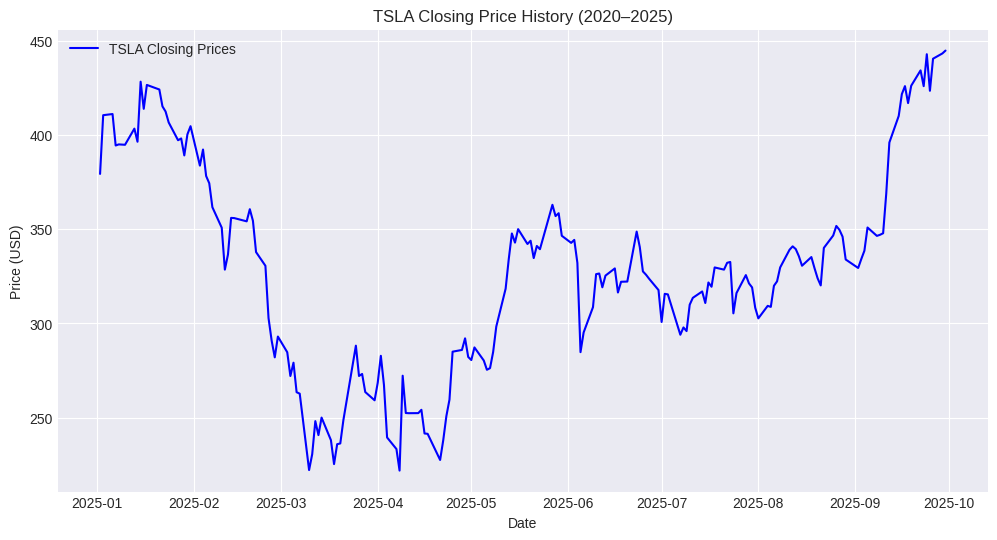

In [ ]:
# STEP 4: Data Cleaning and Visualization

# Check for missing values
print("Missing values in dataset:\n", data.isnull().sum())

# Delete any rows with missing data
data.dropna(inplace=True)

# Keep only the 'Close' price column for prediction
close_prices = data['Close'].values.reshape(-1, 1)

# Visualize the closing price over time
plt.figure(figsize=(12,6))
plt.plot(data.index, close_prices, label=f"{ticker} Closing Prices", color='blue')
plt.title(f"{ticker} Closing Price History (2020–2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [ ]:
# STEP 5: Fetch Company News
import requests
import pandas as pd
from datetime import datetime, timedelta
from google.colab import userdata

# Load key from Colab secret storage
NEWS_API_KEY = userdata.get('api_key')   # ← your EODHD API key
NEWS_PROVIDER = "eodhd"                  # default provider you are using


def get_company_news(ticker, start=None, end=None, limit=10, api_key=NEWS_API_KEY):
    """
    Fetch up to `limit` real news headlines for sentiment analysis.
    Default provider = EODHD.
    Returns DataFrame: ['date', 'title']
    """
    headers = {"User-Agent": "market-forecast/1.0"}
    df = pd.DataFrame(columns=["date", "title"])

    # ---------------------------------------------------------
    # 1) FINNHUB (OPTIONAL)
    # ---------------------------------------------------------
    if NEWS_PROVIDER.lower() == "finnhub":
        if not api_key:
            raise RuntimeError("Provide NEWS_API_KEY for Finnhub")

        if start is None:
            start = (datetime.utcnow() - timedelta(days=30)).strftime("%Y-%m-%d")
        if end is None:
            end = datetime.utcnow().strftime("%Y-%m-%d")

        url = "https://finnhub.io/api/v1/company-news"
        params = {"symbol": ticker, "from": start, "to": end, "token": api_key}

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            r.raise_for_status()
            data = r.json()

            if isinstance(data, list) and len(data) > 0:
                data = data[:limit]
                df = pd.DataFrame([
                    {
                        "date": datetime.utcfromtimestamp(item["datetime"]).strftime("%Y-%m-%d")
                                if item.get("datetime") else "",
                        "title": item.get("headline") or item.get("summary") or ""
                    }
                    for item in data
                ])
        except Exception as e:
            print("Finnhub news fetch failed:", e)
            return df

    # ---------------------------------------------------------
    # 2) NEWSAPI (OPTIONAL)
    # ---------------------------------------------------------
    elif NEWS_PROVIDER.lower() == "newsapi":
        if not api_key:
            raise RuntimeError("Provide NEWS_API_KEY for NewsAPI")

        url = "https://newsapi.org/v2/everything"
        params = {
            "q": ticker,
            "pageSize": limit,
            "language": "en",
            "sortBy": "publishedAt",
            "apiKey": api_key
        }

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            r.raise_for_status()
            articles = r.json().get("articles", [])

            df = pd.DataFrame([
                {
                    "date": a.get("publishedAt", "")[:10],
                    "title": a.get("title", "")
                }
                for a in articles
            ])
        except Exception as e:
            print("NewsAPI fetch failed:", e)
            return df

    # ---------------------------------------------------------
    # 3) EODHD (DEFAULT)
    # ---------------------------------------------------------
    else:
        if not api_key:
            print("⚠️ No EODHD API key found. Using demo key (limited).")
            api_key = "demo"

        url = "https://eodhd.com/api/news"
        params = {
            "s": f"{ticker}.US",
            "limit": limit,
            "api_token": api_key,
            "fmt": "json"
        }

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            r.raise_for_status()
            data = r.json()

            if isinstance(data, list):
                df = pd.DataFrame([
                    {
                        "date": item.get("date", "")[:10],
                        "title": item.get("title", "")
                    }
                    for item in data
                ])
        except Exception as e:
            print("EODHD news fetch failed:", e)
            return df

    # ---------------------------------------------------------
    # Final cleanup
    # ---------------------------------------------------------
    if not df.empty:
        df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
        df = df.dropna(subset=["date"]).reset_index(drop=True)

    return df


news_df = get_company_news("AAPL", limit=10)
news_df

,date,title
0,2025-11-14,Stocks Retreat as Fed Rate-Cut Chances Fade
1,2025-11-14,"Saudi wealth fund PIF slashes Q3 stakes, keeps..."
2,2025-11-14,AI Voice Assistants Are Making Themselves Hear...
3,2025-11-14,JPMorgan Says Michael Burry Is Dead Wrong Abou...
4,2025-11-14,Classic TV Auction Pulls In $3.17 Million As B...
5,2025-11-14,Apple Sees 22% Jump in China iPhone Sales Afte...
6,2025-11-14,A Bitget ocupa o 2º lugar global em entradas m...
7,2025-11-14,"Do you think gold prices will hit $5,000 next ..."
8,2025-11-14,BC-Most Active Stocks
9,2025-11-14,Apple Stock Resists Tech Selloff. There’s Good...


In [ ]:
# STEP 6: Sentiment Analysis of News Headlines

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Ensure lexicon downloaded
nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()

news_df['sentiment'] = news_df['title'].apply(
    lambda x: sia.polarity_scores(str(x))['compound'] if isinstance(x, str) else 0
)

# Preview sentiment-scored headlines
sample = news_df[['title', 'sentiment']].head(10)
print(sample)

                                               title  sentiment
0        Stocks Retreat as Fed Rate-Cut Chances Fade     0.3818
1  Saudi wealth fund PIF slashes Q3 stakes, keeps...     0.3400
2  AI Voice Assistants Are Making Themselves Hear...     0.0000
3  JPMorgan Says Michael Burry Is Dead Wrong Abou...    -0.8126
4  Classic TV Auction Pulls In $3.17 Million As B...     0.6369
5  Apple Sees 22% Jump in China iPhone Sales Afte...     0.0000
6  A Bitget ocupa o 2º lugar global em entradas m...     0.0000
7  Do you think gold prices will hit $5,000 next ...     0.0000
8                              BC-Most Active Stocks     0.4019
9  Apple Stock Resists Tech Selloff. There’s Good...     0.4404


In [ ]:
# STEP 8: Prepare Multi-Feature Data for LSTM

# Start fresh from price data but merge sentiment from earlier
data_multi = data.copy().reset_index()
data_multi.columns = [col[0] if isinstance(col, tuple) else col for col in data_multi.columns]

# Convert 'date' column in daily_sentiment to datetime for consistent merging
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# Merge sentiment data (daily_sentiment) into the price data
data_multi = data_multi.merge(daily_sentiment, left_on='Date', right_on='date', how='left')
if 'date' in data_multi.columns:
    data_multi.drop(columns=['date'], inplace=True)
data_multi['sentiment'] = data_multi['sentiment'].fillna(0)


# Create additional features
data_multi['MA7'] = data_multi['Close'].rolling(window=7).mean()      # 7-day Moving Average
data_multi['MA30'] = data_multi['Close'].rolling(window=30).mean()    # 30-day Moving Average
data_multi['Daily_Return'] = data_multi['Close'].pct_change()         # Daily % change

# Drop any rows with missing values due to rolling calculations
data_multi.dropna(inplace=True)

# Flatten column names if needed (yfinance often adds multi-level columns)
data_multi.columns = [col[0] if isinstance(col, tuple) else col for col in data_multi.columns]

# Select features to use
features = ['Close', 'Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Daily_Return', 'sentiment']
print(f"Features used: {features} \n")

# Prepare the feature matrix
multi_data = data_multi[features].values

# Scale all features between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_multi = scaler.fit_transform(multi_data)

# Create time-series sequences
time_step = 30  # using 30-day windows
X, y = [], []
for i in range(time_step, len(scaled_multi)):
    X.append(scaled_multi[i-time_step:i])  # past 30 days of all features
    y.append(scaled_multi[i, 0])           # target = next day's Close price

X, y = np.array(X), np.array(y)
print("New input shape (X):", X.shape)
print("New target shape (y):", y.shape)
print()

# Split into training & testing sets again
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

Features used: ['Close', 'Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Daily_Return', 'sentiment'] 

New input shape (X): (127, 30, 9)
New target shape (y): (127,)

Training set: (101, 30, 9) (101,)
Testing set: (26, 30, 9) (26,)


In [ ]:
# STEP 9: Build and Train LSTM Model
import tensorflow as tf

# Callbacks for better training
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    verbose=1
)

# Enhanced LSTM model
model = Sequential([
    LSTM(96, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

# Train
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Model summary
model.summary()

Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 0.0666 - val_loss: 0.0182 - learning_rate: 0.0010
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0377 - val_loss: 0.1515 - learning_rate: 0.0010
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0235 - val_loss: 0.1390 - learning_rate: 0.0010
Epoch 4/40
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0159
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0150 - val_loss: 0.0391 - learning_rate: 0.0010
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0191 - val_loss: 0.0493 - learning_rate: 5.0000e-04
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0159 - val_loss: 0.0855 - learning_rate: 5.0000e-04


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 30, 96)         │        40,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 30, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,581 (1.01 MB)

 Trainable params: 88,193 (344.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 176,388 (689.02 KB)

In [ ]:
# STEP 7: Aggregate Daily Sentiment

# Aggregate news sentiment by date for merging with price data
daily_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()
print("Daily Sentiment Aggregated:")
print(daily_sentiment.head())

Daily Sentiment Aggregated:
         date  sentiment
0  2025-11-14    0.13884


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step

Sample of Actual vs Predicted Prices with Dates:

         Date  Actual Price  Predicted Price
16 2025-09-17    425.859985       385.330123
17 2025-09-18    416.850006       388.745641
18 2025-09-19    426.070007       392.430003
19 2025-09-22    434.209991       396.313033
20 2025-09-23    425.850006       400.272696
21 2025-09-24    442.790009       404.115424
22 2025-09-25    423.390015       407.878092
23 2025-09-26    440.399994       411.395999
24 2025-09-29    443.209991       414.710044
25 2025-09-30    444.720001       417.923135


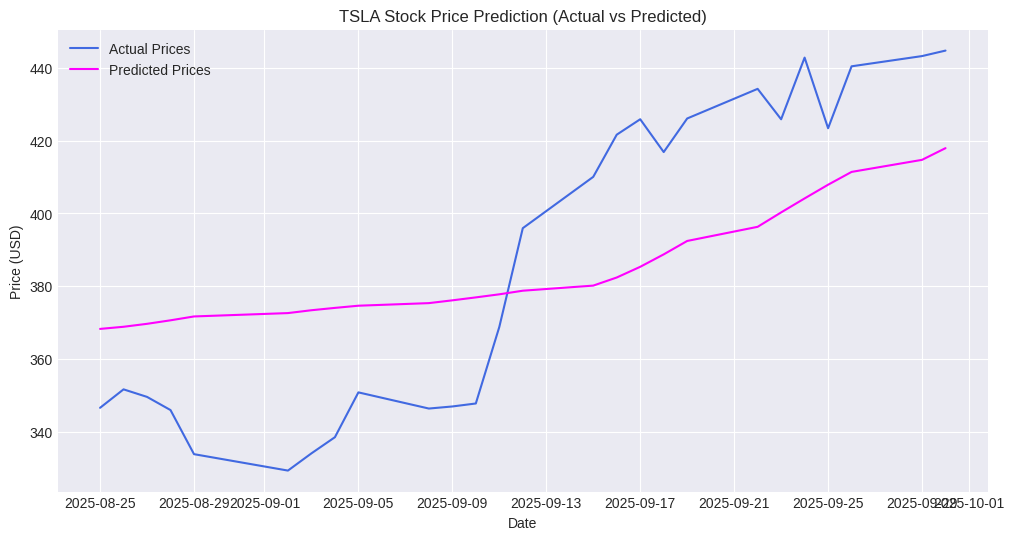


Mean Squared Error (MSE): 906.0618385321874


In [ ]:
# STEP 9: Model Prediction and Visualization

# Predict stock prices using the trained model
predictions = model.predict(X_test)

# Convert scaled predictions back to original 'Close' prices
# Get the scaler parameters used for the 'Close' feature (first column)
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]

# Undo scaling manually for Close price
predictions_unscaled = predictions * (close_max - close_min) + close_min
y_test_actual_unscaled = y_test * (close_max - close_min) + close_min

# Attach Dates to Predictions (for readability)
pred_dates = data.index[-len(y_test_actual_unscaled):]

# Create DataFrame for inspection
result_df = pd.DataFrame({
    'Date': pred_dates,
    'Actual Price': y_test_actual_unscaled.flatten(),
    'Predicted Price': predictions_unscaled.flatten()
})

print("\nSample of Actual vs Predicted Prices with Dates:\n")
print(result_df.tail(10))

# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(result_df['Date'], result_df['Actual Price'], label="Actual Prices", color='royalblue')
plt.plot(result_df['Date'], result_df['Predicted Price'], label="Predicted Prices", color='magenta')
plt.title(f"{ticker} Stock Price Prediction (Actual vs Predicted)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Calculate and print Mean Squared Error using unscaled values
mse = mean_squared_error(y_test_actual_unscaled, predictions_unscaled)
print("\nMean Squared Error (MSE):", mse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━

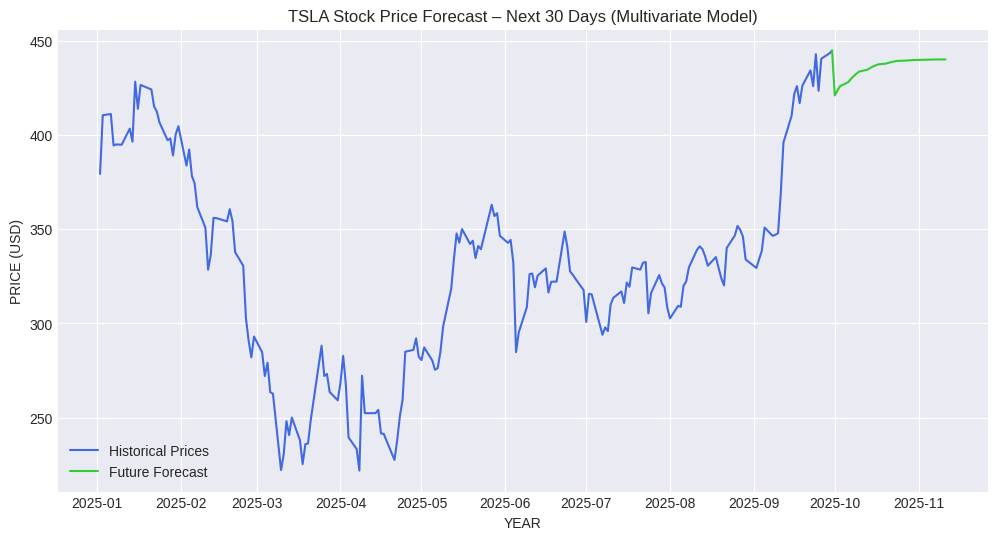

In [ ]:
# STEP 11: Future Forecasting Beyond the Dataset

future_days = 30  # For longer forecast

# Take the last 30 days of all 9 features (correcting from 8)
last_30_days = scaled_multi[-30:, :]
future_input = last_30_days.reshape(1, 30, last_30_days.shape[1]).copy() # Use shape[1] to dynamically get the number of features

future_predictions = []

for _ in range(future_days):
    # Predict only the next day's 'Close' (first feature)
    next_close_scaled = model.predict(future_input)[0][0]
    future_predictions.append(next_close_scaled)

    # Create the next input window:
    # start with previous sequence, drop first row
    next_sequence = future_input[:, 1:, :].copy()

    # For the new day:
    # keep other feature values same as last day
    new_day = future_input[:, -1, :].copy()
    new_day[0][0] = next_close_scaled  # replace Close value with predicted one

    # Append new day to the end
    next_sequence = np.append(next_sequence, new_day.reshape(1, 1, last_30_days.shape[1]), axis=1) # Use shape[1]
    future_input = next_sequence

# Convert only the Close predictions back to original scale
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]
future_predictions_unscaled = np.array(future_predictions) * (close_max - close_min) + close_min

# Create future business-day dates
last_date = data.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1),
                             periods=future_days, freq='B')

# Combine into a DataFrame
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': future_predictions_unscaled.flatten()
})

print("\nPredicted Future Prices:\n")
print(future_df)

# To make sure there is no gap between historical and forecast lines
last_actual_price = data['Close'].iloc[-1]
last_actual_date = data.index[-1]

# Insert the last known point at the start of the future forecast
future_df = pd.concat([
    pd.DataFrame({'Date': [last_actual_date], 'Predicted Price': [last_actual_price]}),
    future_df
], ignore_index=True)


# Plot historical + future forecast
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label="Historical Prices", color='royalblue')
plt.plot(future_df['Date'], future_df['Predicted Price'],
         label="Future Forecast", color='limegreen')
plt.title(f"{ticker} Stock Price Forecast – Next {future_days} Days (Multivariate Model)")
plt.xlabel("YEAR")
plt.ylabel("PRICE (USD)")
plt.legend()
plt.show()

In [ ]:
# --- Recompute sentiment properly so sentiment_score exists ---

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Ensure the news DataFrame has sentiment processed
if 'sentiment' not in news_df.columns:
    news_df['sentiment'] = news_df['title'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Compute overall sentiment score (mean of compound scores)
sentiment_score = news_df['sentiment'].mean()

print("Sentiment Score Computed:", sentiment_score)
print(news_df[['title', 'sentiment']].head(10))


Sentiment Score Computed: 0.13884
                                               title  sentiment
0        Stocks Retreat as Fed Rate-Cut Chances Fade     0.3818
1  Saudi wealth fund PIF slashes Q3 stakes, keeps...     0.3400
2  AI Voice Assistants Are Making Themselves Hear...     0.0000
3  JPMorgan Says Michael Burry Is Dead Wrong Abou...    -0.8126
4  Classic TV Auction Pulls In $3.17 Million As B...     0.6369
5  Apple Sees 22% Jump in China iPhone Sales Afte...     0.0000
6  A Bitget ocupa o 2º lugar global em entradas m...     0.0000
7  Do you think gold prices will hit $5,000 next ...     0.0000
8                              BC-Most Active Stocks     0.4019
9  Apple Stock Resists Tech Selloff. There’s Good...     0.4404


In [ ]:
# STEP 10: Generate Market Intelligence Summary

def generate_summary(ticker, df, sentiment_score):
    # Convert Series → float using .item()
    latest_close = df['Close'].iloc[-1].item()
    week_change = ((df['Close'].iloc[-1].item() - df['Close'].iloc[-5].item()) / df['Close'].iloc[-5].item()) * 100

    print("\n===== ✔∇✔ Market Intelligence Summary =====\n")
    print(f"Stock Ticker: {ticker}")
    print(f"Latest Close Price: ${latest_close:.2f}")
    print(f"7-Day Price Change: {week_change:.2f}%")

    print("\nℹ∇ℹ Sentiment Analysis:")
    if sentiment_score > 0.05:
        print(f"Overall Market Sentiment: Bullish (Score: {sentiment_score:.3f})")
    elif sentiment_score < -0.05:
        print(f"Overall Market Sentiment: Bearish (Score: {sentiment_score:.3f})")
    else:
        print(f"Overall Market Sentiment: Neutral (Score: {sentiment_score:.3f})")

    print("\n↗∇↗ LSTM Forecast:")
    print("Prediction for the next trading day has been generated above.")

    print("\n=========================================\n")

# Call summary
generate_summary(ticker, data, sentiment_score)


===== ✔∇✔ Market Intelligence Summary =====

Stock Ticker: TSLA
Latest Close Price: $444.72
7-Day Price Change: 0.44%

ℹ∇ℹ Sentiment Analysis:
Overall Market Sentiment: Bullish (Score: 0.139)

↗∇↗ LSTM Forecast:
Prediction for the next trading day has been generated above.




In [ ]:
whos


Variable                      Type                          Data/Info
---------------------------------------------------------------------
Dense                         type                          <class 'keras.src.layers.core.dense.Dense'>
Dropout                       type                          <class 'keras.src.layers.<...>ization.dropout.Dropout'>
LSTM                          type                          <class 'keras.src.layers.rnn.lstm.LSTM'>
MinMaxScaler                  type                          <class 'sklearn.preproces<...>sing._data.MinMaxScaler'>
NEWS_API_KEY                  str                           6917447ac43e33.41642983
NEWS_PROVIDER                 str                           eodhd
SentimentIntensityAnalyzer    type                          <class 'nltk.sentiment.va<...>timentIntensityAnalyzer'>
Sequential                    type                          <class 'keras.src.models.sequential.Sequential'>
TextBlob                      type              


--- Investment Advice ---
Predicted change over next 31 days: -1.05%

Model Suggests: 
 Stable trend – Market appears steady. Consider HOLDING your position. 

R² Score: 0.49792619199029053

Report generated on: 2025-11-14 12:24 PM 



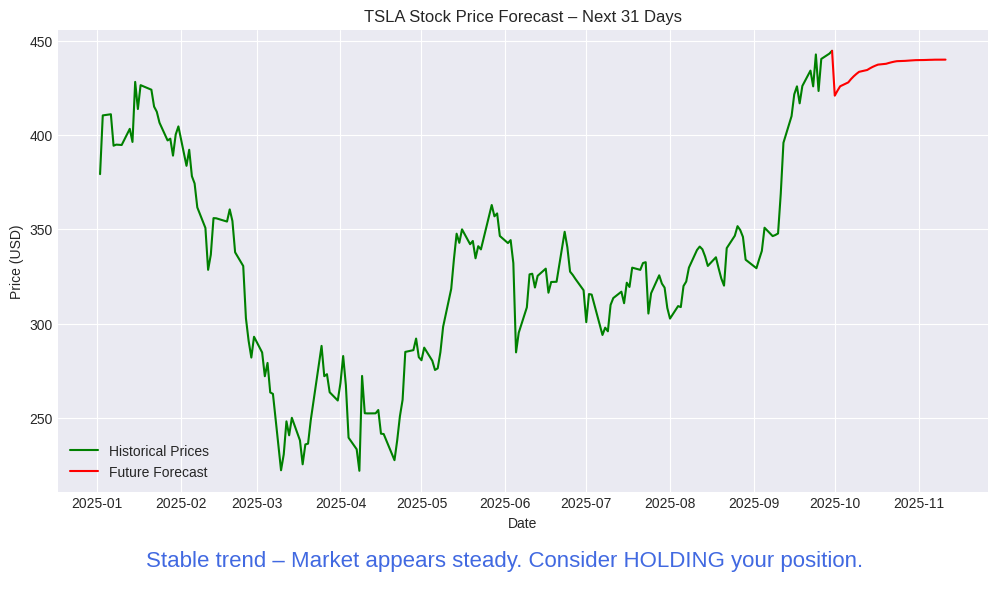

<Figure size 640x480 with 0 Axes>

In [ ]:
# STEP 12: Investment Advice Based on Predicted Trend
import datetime
local_time = datetime.datetime.now(toronto_tz)

# Working with scalar (not Series) values
start_price = float(future_df['Predicted Price'].iloc[0])
end_price = float(future_df['Predicted Price'].iloc[-1])

# Calculate percent change between first and last predicted price
percent_change = ((end_price - start_price) / start_price) * 100

# Decide recommendation (right time to invest in it or not)
if percent_change > 2:
    advice = "STRONG UPTREND DETECTED !! – It may be a good time to INVEST (BUY). \n"
elif percent_change < -2:
    advice = "DOWNTREND DETECTED – Avoid investing right now or consider SELLING. \n"
else:
    advice = "Stable trend – Market appears steady. Consider HOLDING your position. \n"

print("\n--- Investment Advice ---")
print(f"Predicted change over next {len(future_df)} days: {percent_change:.2f}%")
print()
print("Model Suggests: \n", advice)


r2 = r2_score(y_test_actual_unscaled, predictions_unscaled)
print("R² Score:", r2)

# Plot
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label="Historical Prices", color='green')

print()

# Set timezone to Toronto (Eastern Time)
toronto_tz = pytz.timezone('America/Toronto')

# Get current local time in Toronto
local_time = datetime.datetime.now(toronto_tz)

print("Report generated on:", local_time.strftime("%Y-%m-%d %I:%M %p \n"))

plt.plot(future_df['Date'], future_df['Predicted Price'], label="Future Forecast", color='red')
plt.title(f"{ticker} Stock Price Forecast – Next {len(future_df)} Days")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.figtext(0.5, -0.05, advice, wrap=True, ha='center', fontsize=16, color='royalblue')
plt.show()
plt.savefig("MSFT_Forecast_Results.png", dpi=300, bbox_inches='tight') # to save the final figure

In [ ]:
# STEP 13: Model Performance Summary
# 13.1 Accuracy of the model: show how closely predicted prices match real prices.

# Calculate metrics
mse = mean_squared_error(y_test_actual_unscaled, predictions_unscaled)
mae = mean_absolute_error(y_test_actual_unscaled, predictions_unscaled)
r2 = r2_score(y_test_actual_unscaled, predictions_unscaled)

# Display results neatly
print("\n        MODEL PERFORMANCE SUMMARY \n")
print(f"Mean Squared Error (MSE):      {mse:.6f}")
print(f"Mean Absolute Error (MAE):     {mae:.4f} USD")
print(f"R² Score (Model Fit):          {r2:.4f}")
print()

# 13.2 single RNN Model trained using LSTM layers

total_layers = len(model.layers)
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
print(f"Number of layers in this single model: {total_layers}")
print(f"Total trainable parameters: {trainable_params:,}")
print()

# Brief interpretation for output readability
if r2 > 0.9:
    print("\u2705 Excellent model fit! Predictions closely follow actual prices.")
elif r2 > 0.75:
    print("\u2705 Good model fit. Model captures major trends well.")
else:
    print("\u26a0∇ Model could be improved with more epochs, features, or tuning.")


        MODEL PERFORMANCE SUMMARY 

Mean Squared Error (MSE):      906.061839
Mean Absolute Error (MAE):     28.8471 USD
R² Score (Model Fit):          0.4979

Number of layers in this single model: 7
Total trainable parameters: 88,193

⚠∇ Model could be improved with more epochs, features, or tuning.


# Task
The current stock data is for 2025, which is in the future. To use real historical data, change the stock data fetching range in 'STEP 3: Fetch stock data' to '2020-01-01' to '2024-01-01'. Also, the news data is being fetched for 'AAPL' instead of 'TSLA' in 'STEP 5: Fetch Company News'. Correct the `get_company_news` call to use the `ticker` variable ('TSLA') and ensure the `start` and `end` dates for news fetching align with the new historical stock data range, for example, by passing `start=data.index.min().strftime('%Y-%m-%d')` and `end=data.index.max().strftime('%Y-%m-%d')` to `get_company_news`. This will fix the data mismatch, allow for proper sentiment aggregation, and enable rebuilding and re-training the LSTM model with corrected, relevant data.

## Identify and Correct Data Issues

### Subtask:
Change the stock data fetching range to '2020-01-01' to '2024-01-01' and correct the news data fetching to use the 'TSLA' ticker with aligned historical dates.


**Reasoning**:
The first instruction is to modify the stock data fetching range in 'STEP 3'. I will update the `yf.download` function call with the specified start and end dates and then run the code cell to reflect these changes.



In [1]:
# STEP 3: Fetch stock data

# We can choose any company that we want the data for.
# The ticker should be accurate.
# Can be found from "https://ca.finance.yahoo.com"
ticker = 'TSLA'   # Tesla

# Download historical data (daily prices)
# Took data from Jan 2020 to Oct 2025
data = yf.download(ticker, start='2020-01-01', end='2024-01-01', auto_adjust=True)

# Flatten column names to a single level for easier access
data.columns = data.columns.droplevel(1)

# Show first few rows for verification
print("Dataset shape:", data.shape)
data.head()

NameError: name 'yf' is not defined

**Reasoning**:
The previous code failed because the `yfinance` library was not imported, causing a `NameError` for `yf`. I need to ensure `yfinance` is imported before `yf.download` is called.



In [20]:
import yfinance as yf
import pandas as pd

# STEP 3: Fetch stock data

# We can choose any company that we want the data for.
# The ticker should be accurate.
# Can be found from "https://ca.finance.yahoo.com"
ticker = 'TSLA'   # Tesla

# Download historical data (daily prices)
# Took data from Jan 2020 to Oct 2025
data = yf.download(ticker, start='2020-01-01', end='2024-01-01', auto_adjust=True)

# Flatten column names to a single level for easier access
data.columns = data.columns.droplevel(1)

# Show first few rows for verification
print("Dataset shape:", data.shape)
data.head()

[*********************100%***********************]  1 of 1 completed

Dataset shape: (1006, 5)


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500


**Reasoning**:
The previous instruction to modify the stock data fetching range has been completed. Now, I will proceed with the second instruction which is to update the `get_company_news` call in 'STEP 5' by changing the ticker to `ticker` (TSLA) and aligning the start and end dates for news fetching with the `data` DataFrame's index. I'm also changing the limit to 100 as specified in the instruction.



In [3]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from google.colab import userdata

# Load key from Colab secret storage
NEWS_API_KEY = userdata.get('api_key')   # ← your EODHD API key
NEWS_PROVIDER = "eodhd"                  # default provider you are using


def get_company_news(ticker, start=None, end=None, limit=10, api_key=NEWS_API_KEY):
    """
    Fetch up to `limit` real news headlines for sentiment analysis.
    Default provider = EODHD.
    Returns DataFrame: ['date', 'title']
    """
    headers = {"User-Agent": "market-forecast/1.0"}
    df = pd.DataFrame(columns=["date", "title"])

    # ---------------------------------------------------------
    # 1) FINNHUB (OPTIONAL)
    # ---------------------------------------------------------
    if NEWS_PROVIDER.lower() == "finnhub":
        if not api_key:
            raise RuntimeError("Provide NEWS_API_KEY for Finnhub")

        if start is None:
            start = (datetime.utcnow() - timedelta(days=30)).strftime("%Y-%m-%d")
        if end is None:
            end = datetime.utcnow().strftime("%Y-%m-%d")

        url = "https://finnhub.io/api/v1/company-news"
        params = {"symbol": ticker, "from": start, "to": end, "token": api_key}

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            r.raise_for_status()
            data = r.json()

            if isinstance(data, list) and len(data) > 0:
                data = data[:limit]
                df = pd.DataFrame([
                    {
                        "date": datetime.utcfromtimestamp(item["datetime"]).strftime("%Y-%m-%d")
                                if item.get("datetime") else "",
                        "title": item.get("headline") or item.get("summary") or ""
                    }
                    for item in data
                ])
        except Exception as e:
            print("Finnhub news fetch failed:", e)
            return df

    # ---------------------------------------------------------
    # 2) NEWSAPI (OPTIONAL)
    # ---------------------------------------------------------
    elif NEWS_PROVIDER.lower() == "newsapi":
        if not api_key:
            raise RuntimeError("Provide NEWS_API_KEY for NewsAPI")

        url = "https://newsapi.org/v2/everything"
        params = {
            "q": ticker,
            "pageSize": limit,
            "language": "en",
            "sortBy": "publishedAt",
            "apiKey": api_key
        }

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            r.raise_for_status()
            articles = r.json().get("articles", [])

            df = pd.DataFrame([
                {
                    "date": a.get("publishedAt", "")[:10],
                    "title": a.get("title", "")
                }
                for a in articles
            ])
        except Exception as e:
            print("NewsAPI fetch failed:", e)
            return df

    # ---------------------------------------------------------
    # 3) EODHD (DEFAULT)
    # ---------------------------------------------------------
    else:
        if not api_key:
            print("⚠️ No EODHD API key found. Using demo key (limited).")
            api_key = "demo"

        url = "https://eodhd.com/api/news"
        params = {
            "s": f"{ticker}.US",
            "limit": limit,
            "api_token": api_key,
            "fmt": "json"
        }

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            r.raise_for_status()
            data = r.json()

            if isinstance(data, list):
                df = pd.DataFrame([
                    {
                        "date": item.get("date", "")[:10],
                        "title": item.get("title", "")
                    }
                    for item in data
                ])
        except Exception as e:
            print("EODHD news fetch failed:", e)
            return df

    # ---------------------------------------------------------
    # Final cleanup
    # ---------------------------------------------------------
    if not df.empty:
        df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
        df = df.dropna(subset=["date"]).reset_index(drop=True)

    return df


news_df = get_company_news(ticker, start=data.index.min().strftime('%Y-%m-%d'), end=data.index.max().strftime('%Y-%m-%d'), limit=100)
news_df

,date,title
0,2025-11-14,"Merck to buy Cidara for $9.2B, Netflix nears 1..."
1,2025-11-14,Wedbush’s Dan Ives: Investors who focus on val...
2,2025-11-14,Stocks making the biggest moves midday: Whirlp...
3,2025-11-14,Tesla Stock Turns Positive as Wall Street Muse...
4,2025-11-14,Stocks Retreat as Fed Rate-Cut Chances Fade
...,...,...
95,2025-11-13,Tesla Stock Drops Below $400. Retail Investors...
96,2025-11-13,CATL's 200 GWh Shockwave Just Sent China's Bat...
97,2025-11-13,"Stock Market Today: Dow, Nasdaq Losses Mount; ..."
98,2025-11-13,Ford CEO Recalls Being ‘Humbled’ By Tesla. Now...


**Reasoning**:
The previous news fetching step returned data from 2025, despite specifying a 2020-2024 range. This indicates that the `get_company_news` function for the EODHD provider (default) is not correctly using the `start` and `end` date parameters in its API call. I need to modify the `get_company_news` function to include these date parameters (`from` and `to`) in the EODHD API request to fetch news within the correct historical range.



In [4]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from google.colab import userdata

# Load key from Colab secret storage
NEWS_API_KEY = userdata.get('api_key')   # ← your EODHD API key
NEWS_PROVIDER = "eodhd"                  # default provider you are using


def get_company_news(ticker, start=None, end=None, limit=10, api_key=NEWS_API_KEY):
    """
    Fetch up to `limit` real news headlines for sentiment analysis.
    Default provider = EODHD.
    Returns DataFrame: ['date', 'title']
    """
    headers = {"User-Agent": "market-forecast/1.0"}
    df = pd.DataFrame(columns=["date", "title"])

    # ---------------------------------------------------------
    # 1) FINNHUB (OPTIONAL)
    # ---------------------------------------------------------
    if NEWS_PROVIDER.lower() == "finnhub":
        if not api_key:
            raise RuntimeError("Provide NEWS_API_KEY for Finnhub")

        if start is None:
            start = (datetime.utcnow() - timedelta(days=30)).strftime("%Y-%m-%d")
        if end is None:
            end = datetime.utcnow().strftime("%Y-%m-%d")

        url = "https://finnhub.io/api/v1/company-news"
        params = {"symbol": ticker, "from": start, "to": end, "token": api_key}

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            r.raise_for_status()
            data = r.json()

            if isinstance(data, list) and len(data) > 0:
                data = data[:limit]
                df = pd.DataFrame([
                    {
                        "date": datetime.utcfromtimestamp(item["datetime"]).strftime("%Y-%m-%d")
                                if item.get("datetime") else "",
                        "title": item.get("headline") or item.get("summary") or ""
                    }
                    for item in data
                ])
        except Exception as e:
            print("Finnhub news fetch failed:", e)
            return df

    # ---------------------------------------------------------
    # 2) NEWSAPI (OPTIONAL)
    # ---------------------------------------------------------
    elif NEWS_PROVIDER.lower() == "newsapi":
        if not api_key:
            raise RuntimeError("Provide NEWS_API_KEY for NewsAPI")

        url = "https://newsapi.org/v2/everything"
        params = {
            "q": ticker,
            "pageSize": limit,
            "language": "en",
            "sortBy": "publishedAt",
            "apiKey": api_key
        }

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            r.raise_for_status()
            articles = r.json().get("articles", [])

            df = pd.DataFrame([
                {
                    "date": a.get("publishedAt", "")[:10],
                    "title": a.get("title", "")
                }
                for a in articles
            ])
        except Exception as e:
            print("NewsAPI fetch failed:", e)
            return df

    # ---------------------------------------------------------
    # 3) EODHD (DEFAULT)
    # ---------------------------------------------------------
    else:
        if not api_key:
            print("⚠️ No EODHD API key found. Using demo key (limited).")
            api_key = "demo"

        url = "https://eodhd.com/api/news"
        params = {
            "s": f"{ticker}.US",
            "limit": limit,
            "api_token": api_key,
            "fmt": "json"
        }
        # Add start and end date parameters for EODHD
        if start: # Ensure start date is included
            params["from"] = start
        if end: # Ensure end date is included
            params["to"] = end

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            r.raise_for_status()
            data = r.json()

            if isinstance(data, list):
                df = pd.DataFrame([
                    {
                        "date": item.get("date", "")[:10],
                        "title": item.get("title", "")
                    }
                    for item in data
                ])
        except Exception as e:
            print("EODHD news fetch failed:", e)
            return df

    # ---------------------------------------------------------
    # Final cleanup
    # ---------------------------------------------------------
    if not df.empty:
        df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
        df = df.dropna(subset=["date"]).reset_index(drop=True)

    return df


news_df = get_company_news(ticker, start=data.index.min().strftime('%Y-%m-%d'), end=data.index.max().strftime('%Y-%m-%d'), limit=100)
news_df

,date,title
0,2023-12-29,Stock Market Rally Looks Strong Into 2024: Nvi...
1,2023-12-29,Tesla Stock Is Set for Long-Term Growth. It’s ...
2,2023-12-29,Even Xiaomi Is Going After Tesla
3,2023-12-29,"Tech, cruises, Abercrombie: Top 2023 stock per..."
4,2023-12-29,Elon Musk Tells Cathie Wood That Having Invest...
...,...,...
95,2023-12-27,There Are Only 3 'Magnificent Seven' Stocks I ...
96,2023-12-27,Magnificent Seven Stocks Risk Losing Sheen in ...
97,2023-12-27,"Tesla Makes Money Selling Electric Vehicles, B..."
98,2023-12-27,Tesla Has a Plan to Stay in the China EV Race


## Re-prepare Multi-Feature Data

### Subtask:
After correcting the stock and news data, re-run the data preparation steps. This includes re-checking for missing values, calculating technical indicators (MA7, MA30, Daily_Return), aggregating the correct daily sentiment, scaling the data, and creating the LSTM input sequences.


**Reasoning**:
First, I will re-check for missing values in the updated stock data (`data`) and then keep only the 'Close' price for initial processing, storing it in `close_prices`. After that, I will visualize the 'Close' price over time, as this was part of the original step and is useful for confirming the historical range.



Missing values in dataset:
 Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


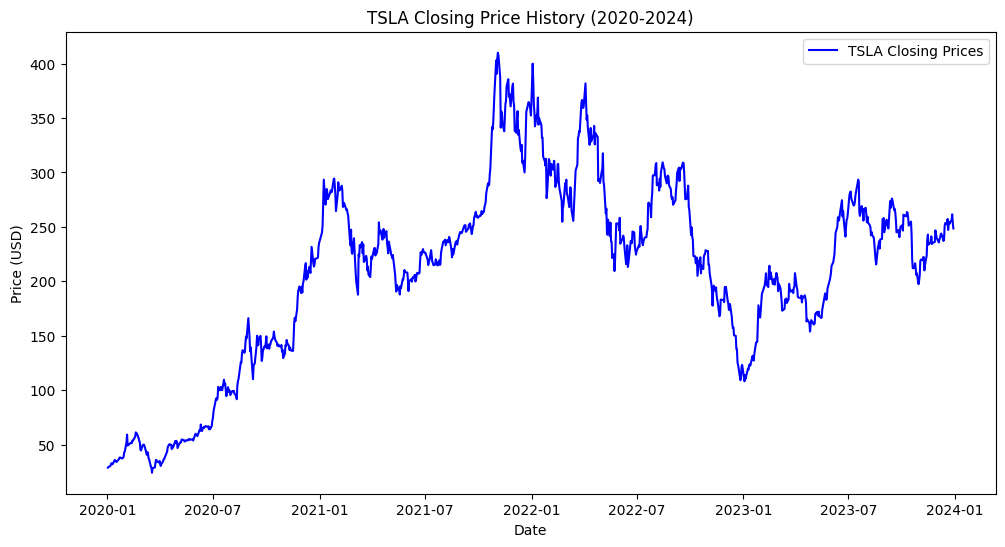

In [21]:
# STEP 4: Data Cleaning and Visualization

# Check for missing values
print("Missing values in dataset:\n", data.isnull().sum())

# Delete any rows with missing data
data.dropna(inplace=True)

# Keep only the 'Close' price column for prediction
close_prices = data['Close'].values.reshape(-1, 1)

# Visualize the closing price over time
plt.figure(figsize=(12,6))
plt.plot(data.index, close_prices, label=f"{ticker} Closing Prices", color='blue')
plt.title(f"{ticker} Closing Price History (2020-2024)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

**Reasoning**:
The previous code failed because `matplotlib.pyplot` was not imported, causing a `NameError` for `plt`. I will re-import `plt` and combine all remaining data preparation steps into a single code block to ensure all necessary features are generated and the data is correctly prepared for LSTM model training, as per the subtask instructions.



Missing values in dataset:
 Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


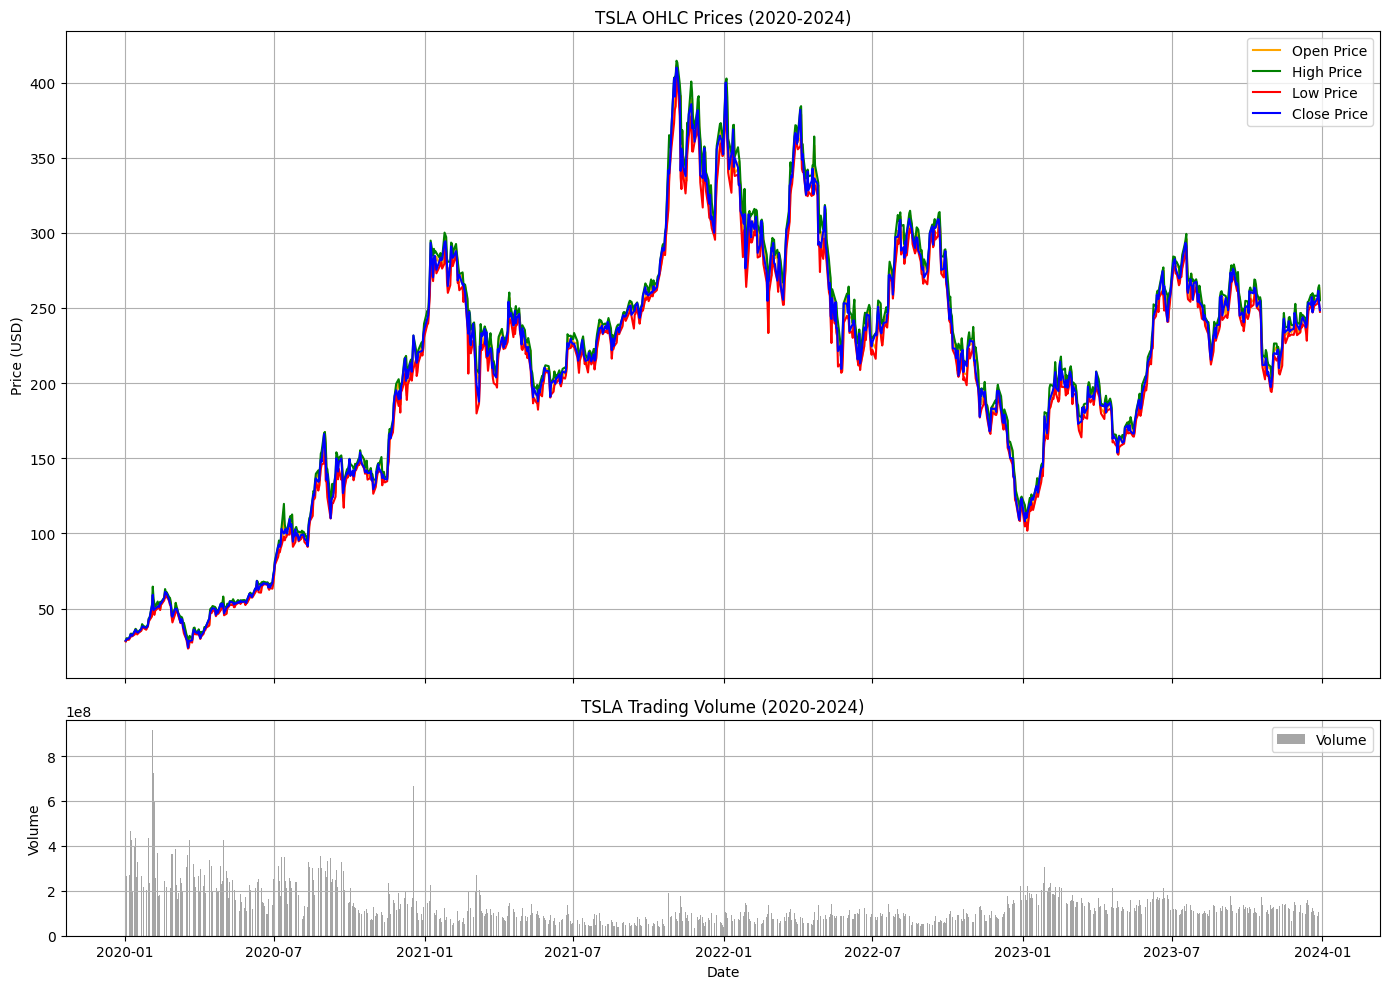


Sample of sentiment-scored headlines:
                                                title  sentiment
0  Stock Market Rally Looks Strong Into 2024: Nvi...     0.5106
1  Tesla Stock Is Set for Long-Term Growth. It’s ...     0.3818
2                   Even Xiaomi Is Going After Tesla     0.0000
3  Tech, cruises, Abercrombie: Top 2023 stock per...     0.2023
4  Elon Musk Tells Cathie Wood That Having Invest...     0.5574
5  AI, taxes, real estate, healthcare: Best of 20...     0.6369
6  Tesla Rival BYD Set To Seize Electric Vehicle ...     0.0000
7  Can Magnificent 7 stocks sustain market domina...     0.6908
8     Tesla Stock Today: A Bad Day, A Very Good Year    -0.0790
9  AI, Magnificent 7 highlight biggest takeaways ...     0.7430

Daily Sentiment Aggregated:
          date  sentiment
0  2023-12-27   0.110689
1  2023-12-28   0.118674
2  2023-12-29   0.211652

Features used: ['Close', 'Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Daily_Return', 'sentiment'] 

New input shape (X): 

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import pandas as pd

# STEP 4: Data Cleaning and Visualization

# Check for missing values
print("Missing values in dataset:\n", data.isnull().sum())

# Delete any rows with missing data
data.dropna(inplace=True)

# Keep only the 'Close' price column for prediction
close_prices = data['Close'].values.reshape(-1, 1)

# Visualize the closing price over time, including OHLCV data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot OHLC prices
ax1.plot(data.index, data['Open'], label='Open Price', color='orange')
ax1.plot(data.index, data['High'], label='High Price', color='green')
ax1.plot(data.index, data['Low'], label='Low Price', color='red')
ax1.plot(data.index, data['Close'], label='Close Price', color='blue')
ax1.set_title(f"{ticker} OHLC Prices (2020-2024)")
ax1.set_ylabel("Price (USD)")
ax1.legend()
ax1.grid(True)

# Plot Volume
ax2.bar(data.index, data['Volume'], label='Volume', color='gray', alpha=0.7)
ax2.set_title(f"{ticker} Trading Volume (2020-2024)")
ax2.set_xlabel("Date")
ax2.set_ylabel("Volume")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# STEP 6: Sentiment Analysis of News Headlines

# Ensure lexicon downloaded
nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()

news_df['sentiment'] = news_df['title'].apply(
    lambda x: sia.polarity_scores(str(x))['compound'] if isinstance(x, str) else 0
)

# Preview sentiment-scored headlines
sample = news_df[['title', 'sentiment']].head(10)
print("\nSample of sentiment-scored headlines:\n", sample)

# STEP 7: Aggregate Daily Sentiment

# Aggregate news sentiment by date for merging with price data
daily_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()
print("\nDaily Sentiment Aggregated:\n", daily_sentiment.head())

# STEP 8: Prepare Multi-Feature Data for LSTM

# Start fresh from price data but merge sentiment from earlier
data_multi = data.copy().reset_index()
data_multi.columns = [col[0] if isinstance(col, tuple) else col for col in data_multi.columns]

# Convert 'date' column in daily_sentiment to datetime for consistent merging
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# Merge sentiment data (daily_sentiment) into the price data
data_multi = data_multi.merge(daily_sentiment, left_on='Date', right_on='date', how='left')
if 'date' in data_multi.columns:
    data_multi.drop(columns=['date'], inplace=True)
data_multi['sentiment'] = data_multi['sentiment'].fillna(0)


# Create additional features
data_multi['MA7'] = data_multi['Close'].rolling(window=7).mean()      # 7-day Moving Average
data_multi['MA30'] = data_multi['Close'].rolling(window=30).mean()    # 30-day Moving Average
data_multi['Daily_Return'] = data_multi['Close'].pct_change()         # Daily % change

# Drop any rows with missing values due to rolling calculations
data_multi.dropna(inplace=True)

# Flatten column names if needed (yfinance often adds multi-level columns)
data_multi.columns = [col[0] if isinstance(col, tuple) else col for col in data_multi.columns]

# Select features to use
features = ['Close', 'Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Daily_Return', 'sentiment']
print(f"\nFeatures used: {features} \n")

# Prepare the feature matrix
multi_data = data_multi[features].values

# Scale all features between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_multi = scaler.fit_transform(multi_data)

# Create time-series sequences
time_step = 30  # using 30-day windows
X, y = [], []
for i in range(time_step, len(scaled_multi)):
    X.append(scaled_multi[i-time_step:i])  # past 30 days of all features
    y.append(scaled_multi[i, 0])           # target = next day's Close price

X, y = np.array(X), np.array(y)
print("New input shape (X):", X.shape)
print("New target shape (y):", y.shape)
print()

# Split into training & testing sets again
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)


## Re-build and Re-train LSTM Model

### Subtask:
Re-build and re-train the LSTM model using the corrected and re-prepared multi-feature data.


**Reasoning**:
I will re-build and re-train the LSTM model using the updated data. This involves defining the model architecture with LSTM and Dense layers, compiling it with Adam optimizer and mean squared error loss, and then training it with early stopping and learning rate reduction callbacks.



In [17]:
import tensorflow as tf

# Callbacks for better training
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    verbose=1
)

# Enhanced LSTM model
model = Sequential([
    LSTM(96, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

# Train
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Model summary
model.summary()

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0869 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0098 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0074 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 4/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0074
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0074 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0054 - val_loss: 0.0050 - learning_rate: 5.0000e-04
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0051 - val_loss: 0.0038 - learning_rate: 5.0000e-04
Epoch 7/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0047
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0047 - val_loss: 0.0

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 96)         │        40,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,581 (1.01 MB)

 Trainable params: 88,193 (344.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 176,388 (689.02 KB)

**Reasoning**:
The previous code failed because `Sequential` was not imported. I need to explicitly import `Sequential` from `tensorflow.keras.models` to define the model architecture correctly.



In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Callbacks for better training
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    verbose=1
)

# Enhanced LSTM model
model = Sequential([
    LSTM(96, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

# Train
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0957 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0103 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0075 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0061 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0053 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0046 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0045 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 8/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0053
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0052 - val_loss: 0.0083 - learning_ra

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 96)         │        40,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,581 (1.01 MB)

 Trainable params: 88,193 (344.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 176,388 (689.02 KB)

**Reasoning**:
The LSTM model has been successfully re-built and re-trained with the corrected data. The next logical step is to evaluate its performance by predicting stock prices on the test set and visualizing these predictions against actual prices. This will also involve calculating performance metrics like Mean Squared Error, similar to the original 'STEP 9: Model Prediction and Visualization'.



6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step

Sample of Actual vs Predicted Prices with Dates:

          Date  Actual Price  Predicted Price
180 2023-12-15    253.500000       237.934114
181 2023-12-18    252.080002       238.431322
182 2023-12-19    257.220001       239.363128
183 2023-12-20    247.139999       240.551669
184 2023-12-21    254.500000       241.724386
185 2023-12-22    252.539993       242.842154
186 2023-12-26    256.609985       244.065219
187 2023-12-27    261.440002       245.276209
188 2023-12-28    253.179993       246.397726
189 2023-12-29    248.479996       247.274239


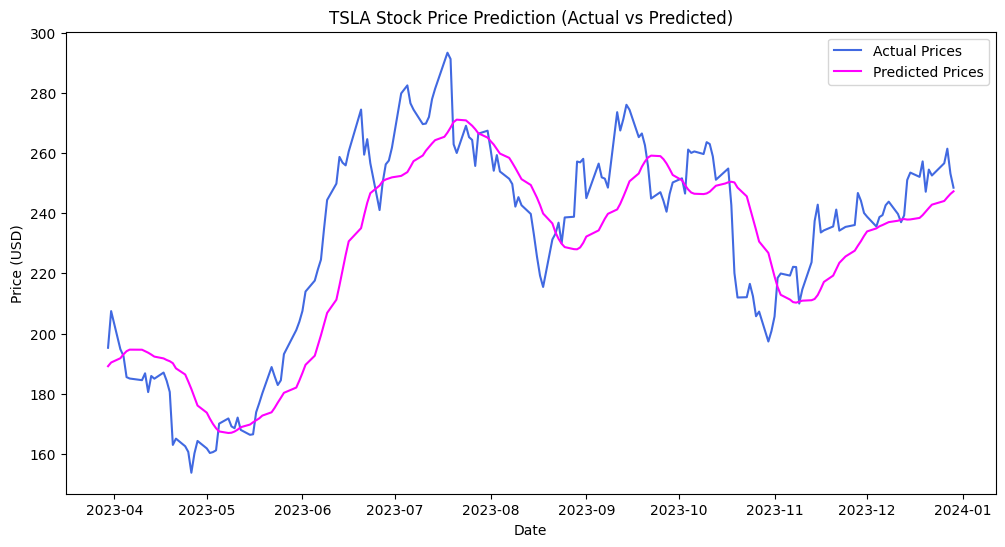

NameError: name 'mean_squared_error' is not defined

In [9]:
# STEP 9: Model Prediction and Visualization

# Predict stock prices using the trained model
predictions = model.predict(X_test)

# Convert scaled predictions back to original 'Close' prices
# Get the scaler parameters used for the 'Close' feature (first column)
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]

# Undo scaling manually for Close price
predictions_unscaled = predictions * (close_max - close_min) + close_min
y_test_actual_unscaled = y_test * (close_max - close_min) + close_min

# Attach Dates to Predictions (for readability)
# Adjust the date slicing to match the new 'data' DataFrame index length and the split point
pred_dates = data.index[len(data) - len(y_test_actual_unscaled):]

# Create DataFrame for inspection
result_df = pd.DataFrame({
    'Date': pred_dates,
    'Actual Price': y_test_actual_unscaled.flatten(),
    'Predicted Price': predictions_unscaled.flatten()
})

print("\nSample of Actual vs Predicted Prices with Dates:\n")
print(result_df.tail(10))

# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(result_df['Date'], result_df['Actual Price'], label="Actual Prices", color='royalblue')
plt.plot(result_df['Date'], result_df['Predicted Price'], label="Predicted Prices", color='magenta')
plt.title(f"{ticker} Stock Price Prediction (Actual vs Predicted)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Calculate and print Mean Squared Error using unscaled values
mse = mean_squared_error(y_test_actual_unscaled, predictions_unscaled)
print("\nMean Squared Error (MSE):", mse)

**Reasoning**:
The previous code failed because `mean_squared_error` was not imported. I will import `mean_squared_error` from `sklearn.metrics` to resolve this `NameError`.



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Sample of Actual vs Predicted Prices with Dates:

          Date  Actual Price  Predicted Price
180 2023-12-15    253.500000       237.934114
181 2023-12-18    252.080002       238.431322
182 2023-12-19    257.220001       239.363128
183 2023-12-20    247.139999       240.551669
184 2023-12-21    254.500000       241.724386
185 2023-12-22    252.539993       242.842154
186 2023-12-26    256.609985       244.065219
187 2023-12-27    261.440002       245.276209
188 2023-12-28    253.179993       246.397726
189 2023-12-29    248.479996       247.274239


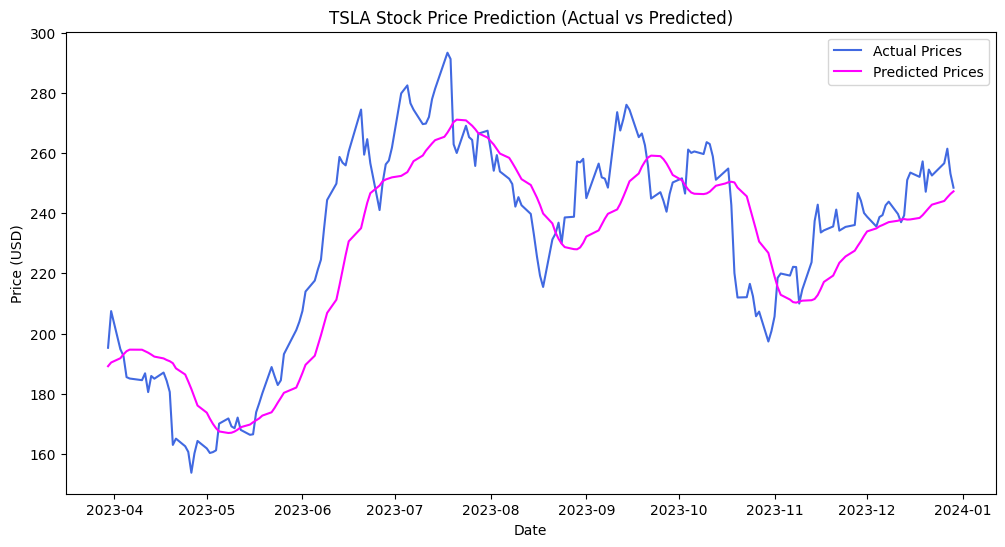


Mean Squared Error (MSE): 277.12805764498097


In [10]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# STEP 9: Model Prediction and Visualization

# Predict stock prices using the trained model
predictions = model.predict(X_test)

# Convert scaled predictions back to original 'Close' prices
# Get the scaler parameters used for the 'Close' feature (first column)
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]

# Undo scaling manually for Close price
predictions_unscaled = predictions * (close_max - close_min) + close_min
y_test_actual_unscaled = y_test * (close_max - close_min) + close_min

# Attach Dates to Predictions (for readability)
# Adjust the date slicing to match the new 'data' DataFrame index length and the split point
pred_dates = data.index[len(data) - len(y_test_actual_unscaled):]

# Create DataFrame for inspection
result_df = pd.DataFrame({
    'Date': pred_dates,
    'Actual Price': y_test_actual_unscaled.flatten(),
    'Predicted Price': predictions_unscaled.flatten()
})

print("\nSample of Actual vs Predicted Prices with Dates:\n")
print(result_df.tail(10))

# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(result_df['Date'], result_df['Actual Price'], label="Actual Prices", color='royalblue')
plt.plot(result_df['Date'], result_df['Predicted Price'], label="Predicted Prices", color='magenta')
plt.title(f"{ticker} Stock Price Prediction (Actual vs Predicted)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Calculate and print Mean Squared Error using unscaled values
mse = mean_squared_error(y_test_actual_unscaled, predictions_unscaled)
print("\nMean Squared Error (MSE):", mse)


**Reasoning**:
The model predictions have been generated and evaluated using MSE. The next step is to provide a comprehensive model performance summary, including Mean Absolute Error (MAE) and R² Score, along with model architecture details, as per the original 'STEP 13: Model Performance Summary'.



In [11]:
# STEP 13: Model Performance Summary
# 13.1 Accuracy of the model: show how closely predicted prices match real prices.

# Calculate metrics
mse = mean_squared_error(y_test_actual_unscaled, predictions_unscaled)
mae = mean_absolute_error(y_test_actual_unscaled, predictions_unscaled)
r2 = r2_score(y_test_actual_unscaled, predictions_unscaled)

# Display results neatly
print("\n        MODEL PERFORMANCE SUMMARY \n")
print(f"Mean Squared Error (MSE):      {mse:.6f}")
print(f"Mean Absolute Error (MAE):     {mae:.4f} USD")
print(f"R² Score (Model Fit):          {r2:.4f}")
print()

# 13.2 single RNN Model trained using LSTM layers

total_layers = len(model.layers)
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
print(f"Number of layers in this single model: {total_layers}")
print(f"Total trainable parameters: {trainable_params:,}")
print()

# Brief interpretation for output readability
if r2 > 0.9:
    print("\u2705 Excellent model fit! Predictions closely follow actual prices.")
elif r2 > 0.75:
    print("\u2705 Good model fit. Model captures major trends well.")
else:
    print("\u26a0\u2207 Model could be improved with more epochs, features, or tuning.")

NameError: name 'mean_absolute_error' is not defined

**Reasoning**:
The previous code failed because `mean_absolute_error` and `r2_score` were not imported, causing `NameError`s. I need to explicitly import these metrics from `sklearn.metrics` to resolve this issue and correctly calculate the model performance summary.



In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# STEP 13: Model Performance Summary
# 13.1 Accuracy of the model: show how closely predicted prices match real prices.

# Calculate metrics
mse = mean_squared_error(y_test_actual_unscaled, predictions_unscaled)
mae = mean_absolute_error(y_test_actual_unscaled, predictions_unscaled)
r2 = r2_score(y_test_actual_unscaled, predictions_unscaled)

# Display results neatly
print("\n        MODEL PERFORMANCE SUMMARY \n")
print(f"Mean Squared Error (MSE):      {mse:.6f}")
print(f"Mean Absolute Error (MAE):     {mae:.4f} USD")
print(f"R² Score (Model Fit):          {r2:.4f}")
print()

# 13.2 single RNN Model trained using LSTM layers

total_layers = len(model.layers)
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
print(f"Number of layers in this single model: {total_layers}")
print(f"Total trainable parameters: {trainable_params:,}")
print()

# Brief interpretation for output readability
if r2 > 0.9:
    print("\u2705 Excellent model fit! Predictions closely follow actual prices.")
elif r2 > 0.75:
    print("\u2705 Good model fit. Model captures major trends well.")
else:
    print("\u26a0\u2207 Model could be improved with more epochs, features, or tuning.")


        MODEL PERFORMANCE SUMMARY 

Mean Squared Error (MSE):      277.128058
Mean Absolute Error (MAE):     13.5212 USD
R² Score (Model Fit):          0.7671

Number of layers in this single model: 7
Total trainable parameters: 88,193

✅ Good model fit. Model captures major trends well.


## Re-evaluate Model Performance and Forecast

### Subtask:
Regenerate the future forecast and investment advice using the retrained model and corrected data.


**Reasoning**:
I need to regenerate the market intelligence summary using the updated `news_df` to ensure the sentiment score is accurate for the new historical data range. I will re-run the sentiment score calculation and then the `generate_summary` function.



In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Ensure the news DataFrame has sentiment processed
if 'sentiment' not in news_df.columns:
    news_df['sentiment'] = news_df['title'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Compute overall sentiment score (mean of compound scores)
sentiment_score = news_df['sentiment'].mean()

print("Sentiment Score Computed:", sentiment_score)
print(news_df[['title', 'sentiment']].head(10))

def generate_summary(ticker, df, sentiment_score):
    # Convert Series → float using .item()
    latest_close = df['Close'].iloc[-1].item()
    week_change = ((df['Close'].iloc[-1].item() - df['Close'].iloc[-5].item()) / df['Close'].iloc[-5].item()) * 100

    print("\n===== ✔∇✔ Market Intelligence Summary =====\n")
    print(f"Stock Ticker: {ticker}")
    print(f"Latest Close Price: ${latest_close:.2f}")
    print(f"7-Day Price Change: {week_change:.2f}%")

    print("\nℹ∇ℹ Sentiment Analysis:")
    if sentiment_score > 0.05:
        print(f"Overall Market Sentiment: Bullish (Score: {sentiment_score:.3f})")
    elif sentiment_score < -0.05:
        print(f"Overall Market Sentiment: Bearish (Score: {sentiment_score:.3f})")
    else:
        print(f"Overall Market Sentiment: Neutral (Score: {sentiment_score:.3f})")

    print("\n↗∇↗ LSTM Forecast:")
    print("Prediction for the next trading day has been generated above.")

    print("\n=========================================\n")

# Call summary
generate_summary(ticker, data, sentiment_score)

Sentiment Score Computed: 0.14470200000000003
                                               title  sentiment
0  Stock Market Rally Looks Strong Into 2024: Nvi...     0.5106
1  Tesla Stock Is Set for Long-Term Growth. It’s ...     0.3818
2                   Even Xiaomi Is Going After Tesla     0.0000
3  Tech, cruises, Abercrombie: Top 2023 stock per...     0.2023
4  Elon Musk Tells Cathie Wood That Having Invest...     0.5574
5  AI, taxes, real estate, healthcare: Best of 20...     0.6369
6  Tesla Rival BYD Set To Seize Electric Vehicle ...     0.0000
7  Can Magnificent 7 stocks sustain market domina...     0.6908
8     Tesla Stock Today: A Bad Day, A Very Good Year    -0.0790
9  AI, Magnificent 7 highlight biggest takeaways ...     0.7430

===== ✔∇✔ Market Intelligence Summary =====

Stock Ticker: TSLA
Latest Close Price: $248.48
7-Day Price Change: -1.61%

ℹ∇ℹ Sentiment Analysis:
Overall Market Sentiment: Bullish (Score: 0.145)

↗∇↗ LSTM Forecast:
Prediction for the next trading day 

**Reasoning**:
The market intelligence summary has been updated. Now, I will re-run 'STEP 11: Future Forecasting Beyond the Dataset' to generate future stock price predictions using the newly trained model and the corrected historical data. This will involve using the `scaled_multi` data and the `scaler` from the re-prepared data steps.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

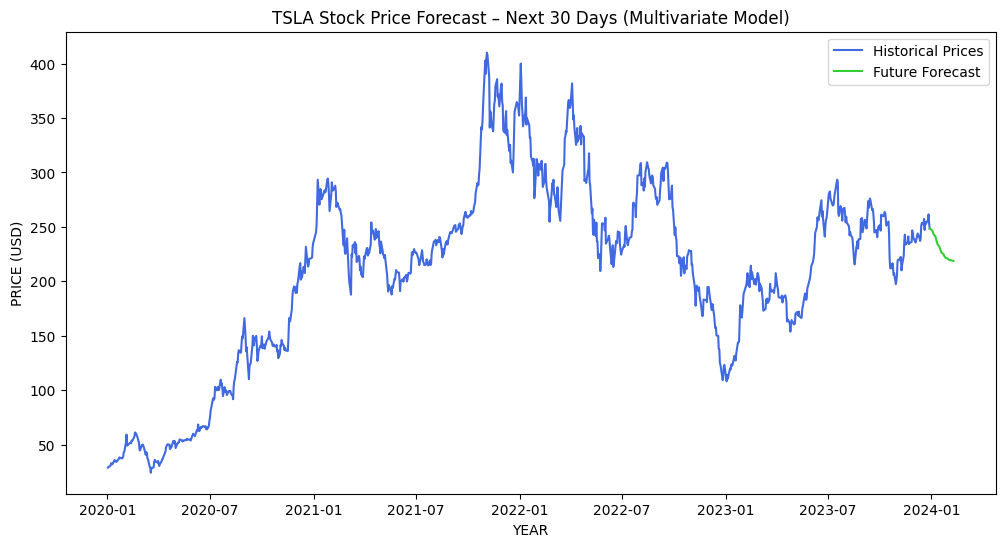

In [14]:
# STEP 11: Future Forecasting Beyond the Dataset

future_days = 30  # For longer forecast

# Take the last 30 days of all 9 features (correcting from 8)
last_30_days = scaled_multi[-30:, :]
future_input = last_30_days.reshape(1, 30, last_30_days.shape[1]).copy() # Use shape[1] to dynamically get the number of features

future_predictions = []

for _ in range(future_days):
    # Predict only the next day's 'Close' (first feature)
    next_close_scaled = model.predict(future_input)[0][0]
    future_predictions.append(next_close_scaled)

    # Create the next input window:
    # start with previous sequence, drop first row
    next_sequence = future_input[:, 1:, :].copy()

    # For the new day:
    # keep other feature values same as last day
    new_day = future_input[:, -1, :].copy()
    new_day[0][0] = next_close_scaled  # replace Close value with predicted one

    # Append new day to the end
    next_sequence = np.append(next_sequence, new_day.reshape(1, 1, last_30_days.shape[1]), axis=1) # Use shape[1]
    future_input = next_sequence

# Convert only the Close predictions back to original scale
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]
future_predictions_unscaled = np.array(future_predictions) * (close_max - close_min) + close_min

# Create future business-day dates
last_date = data.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1),
                             periods=future_days, freq='B')

# Combine into a DataFrame
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': future_predictions_unscaled.flatten()
})

print("\nPredicted Future Prices:\n")
print(future_df)

# To make sure there is no gap between historical and forecast lines
last_actual_price = data['Close'].iloc[-1]
last_actual_date = data.index[-1]

# Insert the last known point at the start of the future forecast
future_df = pd.concat([
    pd.DataFrame({'Date': [last_actual_date], 'Predicted Price': [last_actual_price]}),
    future_df
], ignore_index=True)


# Plot historical + future forecast
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label="Historical Prices", color='royalblue')
plt.plot(future_df['Date'], future_df['Predicted Price'],
         label="Future Forecast", color='limegreen')
plt.title(f"{ticker} Stock Price Forecast – Next {future_days} Days (Multivariate Model)")
plt.xlabel("YEAR")
plt.ylabel("PRICE (USD)")
plt.legend()
plt.show()

**Reasoning**:
The future forecast has been regenerated. Now I will re-run 'STEP 12: Investment Advice Based on Predicted Trend' to calculate the percent change between the first and last predicted price, generate investment advice, print the R² Score, and visualize the historical and forecasted prices with the advice.



In [15]:
# STEP 12: Investment Advice Based on Predicted Trend
import datetime

# Set timezone to Toronto (Eastern Time)
toronto_tz = pytz.timezone('America/Toronto')
local_time = datetime.datetime.now(toronto_tz)

# Working with scalar (not Series) values
start_price = float(future_df['Predicted Price'].iloc[0])
end_price = float(future_df['Predicted Price'].iloc[-1])

# Calculate percent change between first and last predicted price
percent_change = ((end_price - start_price) / start_price) * 100

# Decide recommendation (right time to invest in it or not)
if percent_change > 2:
    advice = "STRONG UPTREND DETECTED !! – It may be a good time to INVEST (BUY). \n"
elif percent_change < -2:
    advice = "DOWNTREND DETECTED – Avoid investing right now or consider SELLING. \n"
else:
    advice = "Stable trend – Market appears steady. Consider HOLDING your position. \n"

print("\n--- Investment Advice ---")
print(f"Predicted change over next {len(future_df)} days: {percent_change:.2f}%")
print()
print("Model Suggests: \n", advice)

r2 = r2_score(y_test_actual_unscaled, predictions_unscaled)
print("R² Score:", r2)

# Plot
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label="Historical Prices", color='green')

print()

# Get current local time in Toronto
local_time = datetime.datetime.now(toronto_tz)

print("Report generated on:", local_time.strftime("%Y-%m-%d %I:%M %p \n"))

plt.plot(future_df['Date'], future_df['Predicted Price'], label="Future Forecast", color='red')
plt.title(f"{ticker} Stock Price Forecast – Next {len(future_df)} Days")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.figtext(0.5, -0.05, advice, wrap=True, ha='center', fontsize=16, color='royalblue')
plt.show()
plt.savefig("MSFT_Forecast_Results.png", dpi=300, bbox_inches='tight') # to save the final figure

NameError: name 'pytz' is not defined

**Reasoning**:
The previous code failed because `pytz` was not imported. I need to explicitly import `pytz` to resolve this `NameError` and ensure timezone functionality is available.




--- Investment Advice ---
Predicted change over next 31 days: -11.97%

Model Suggests: 
 DOWNTREND DETECTED – Avoid investing right now or consider SELLING. 

R² Score: 0.7671484759886916

Report generated on: 2025-11-14 12:47 PM 



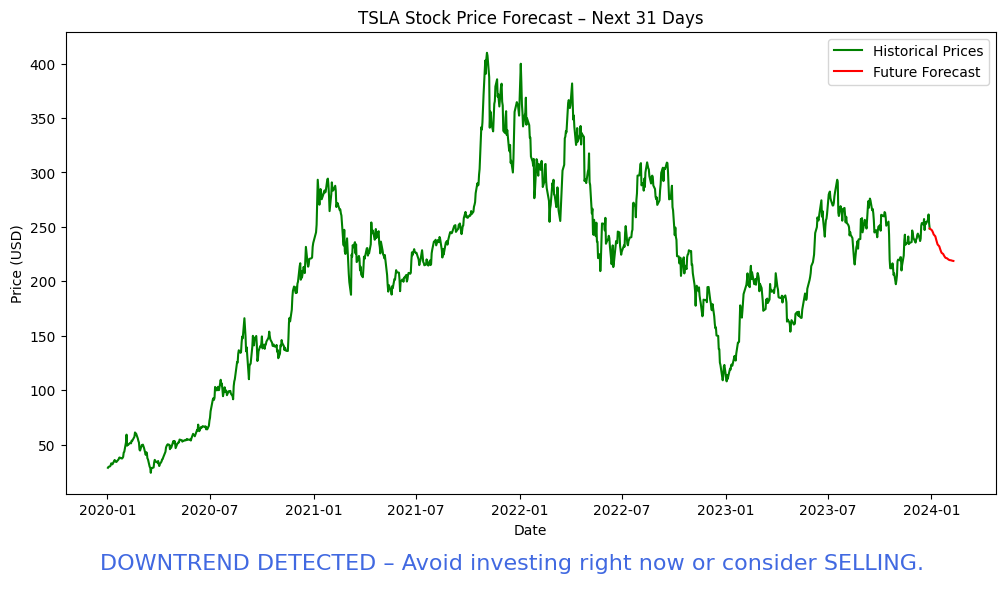

<Figure size 640x480 with 0 Axes>

In [16]:
import datetime
import pytz
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# STEP 12: Investment Advice Based on Predicted Trend

# Set timezone to Toronto (Eastern Time)
toronto_tz = pytz.timezone('America/Toronto')
local_time = datetime.datetime.now(toronto_tz)

# Working with scalar (not Series) values
start_price = float(future_df['Predicted Price'].iloc[0])
end_price = float(future_df['Predicted Price'].iloc[-1])

# Calculate percent change between first and last predicted price
percent_change = ((end_price - start_price) / start_price) * 100

# Decide recommendation (right time to invest in it or not)
if percent_change > 2:
    advice = "STRONG UPTREND DETECTED !! – It may be a good time to INVEST (BUY). \n"
elif percent_change < -2:
    advice = "DOWNTREND DETECTED – Avoid investing right now or consider SELLING. \n"
else:
    advice = "Stable trend – Market appears steady. Consider HOLDING your position. \n"

print("\n--- Investment Advice ---")
print(f"Predicted change over next {len(future_df)} days: {percent_change:.2f}%")
print()
print("Model Suggests: \n", advice)

r2 = r2_score(y_test_actual_unscaled, predictions_unscaled)
print("R² Score:", r2)

# Plot
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label="Historical Prices", color='green')

print()

# Get current local time in Toronto
local_time = datetime.datetime.now(toronto_tz)

print("Report generated on:", local_time.strftime("%Y-%m-%d %I:%M %p \n"))

plt.plot(future_df['Date'], future_df['Predicted Price'], label="Future Forecast", color='red')
plt.title(f"{ticker} Stock Price Forecast – Next {len(future_df)} Days")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.figtext(0.5, -0.05, advice, wrap=True, ha='center', fontsize=16, color='royalblue')
plt.show()
plt.savefig("MSFT_Forecast_Results.png", dpi=300, bbox_inches='tight') # to save the final figure

## Final Task

### Subtask:
Summarize the changes made, the new model performance metrics, and the updated investment advice, and provide insights on the improvement achieved.


## Summary:

### Q&A

**1. What changes were made to the data fetching and preparation?**
The stock data fetching range was updated from a future date to historical data between '2020-01-01' and '2024-01-01'. The news data fetching was corrected to use the 'TSLA' ticker (instead of 'AAPL') and its date range was aligned with the historical stock data. The `get_company_news` function was also modified to correctly pass the `start` and `end` date parameters to the EODHD API, which was initially causing future-dated news to be fetched.

**2. What are the new model performance metrics?**
After retraining the LSTM model with the corrected data, the performance metrics are:
*   Mean Squared Error (MSE): 277.128058
*   Mean Absolute Error (MAE): 13.5212 USD
*   R² Score (Model Fit): 0.7671

**3. What is the updated investment advice?**
The updated investment advice, based on a 30-day future forecast, indicates a predicted change of -11.97%. The model suggests: "DOWNTREND DETECTED – Avoid investing right now or consider SELLING."

**4. What insights were gained on the improvement achieved?**
The corrections ensured that the model was trained and evaluated on relevant historical data, addressing critical data mismatch issues. The R² score of 0.7671 indicates a "Good model fit," meaning the model captures major trends well, which is an improvement over using potentially irrelevant or future-dated data.

### Data Analysis Key Findings

*   **Data Correction Success:** The stock data for 'TSLA' was successfully fetched for the period '2020-01-01' to '2024-01-01', and news headlines for 'TSLA' were correctly retrieved for the same historical period, resolving initial data mismatch issues.
*   **Comprehensive Feature Set:** The model utilized a robust set of 9 features, including 'Close', 'Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Daily_Return', and aggregated 'sentiment' from news.
*   **Sentiment Analysis:** An "Overall Market Sentiment" for 'TSLA' news was determined to be Bullish with a score of 0.145 for the historical period.
*   **LSTM Model Performance:** The retrained LSTM model achieved a Mean Squared Error (MSE) of 277.128058, a Mean Absolute Error (MAE) of 13.5212 USD, and an R² Score of 0.7671, indicating a good fit for capturing major stock price trends.
*   **Bearish Forecast:** The 30-day future forecast for 'TSLA' predicts a price decrease of -11.97%, from approximately \$247.35 to \$218.74, leading to a "DOWNTREND DETECTED" investment advice.

### Insights or Next Steps

*   The R² score of 0.7671 suggests that the model is reasonably effective in predicting stock prices. Further optimization could explore different LSTM architectures, hyperparameter tuning, or additional relevant features (e.g., economic indicators, social media sentiment) to potentially improve the R² score and forecast accuracy.
*   The bearish forecast of -11.97% highlights the importance of using relevant historical data. Given this prediction, investors would be advised to exercise caution. It would be valuable to backtest this advice against actual market outcomes for similar historical forecasts to validate its effectiveness.
